### 모두를 위한 머신러닝/딥러닝 강의
김성훈 교수님의 모두를 위한 머신러닝/딥러닝 강의 중 lab 강의 코드입니다.
## Lab11_5 CNN MNIST (Ensemble : bagging)
Lab11_4의 CNN_for_MNIST Class를 활용합니다.

### CNN_for_MNIST Class

In [1]:
import os, sys 
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
class CNN_for_MNIST:
    
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self.build_net()
        
    def build_net(self):
        
        with tf.variable_scope(self.name):
            
            with tf.variable_scope('CNN_weights'):
                                
                weights = {'wc1' : tf.get_variable(name = 'wc1', shape = [3, 3, 1, 32],
                                                   initializer =  tf.contrib.layers.xavier_initializer()),
                    'wc2' : tf.get_variable(name = 'wc2', shape = [3, 3, 32, 64],
                                            initializer = tf.contrib.layers.xavier_initializer()),
                    'wc3' : tf.get_variable(name = 'wc3', shape = [3, 3, 64, 128],
                                            initializer = tf.contrib.layers.xavier_initializer()),
                    'wd' :  tf.get_variable(name = 'wd', shape = [4 * 4 * 128, 10],
                                            initializer = tf.contrib.layers.xavier_initializer())}
            
            with tf.variable_scope('CNN_bias'):
                
                biases = {'bc1' : tf.get_variable(name = 'bc1', shape = [32],
                                                  initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1)),
                          'bc2' : tf.get_variable(name = 'bc2', shape = [64],
                                                  initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1)),
                          'bc3' : tf.get_variable(name = 'bc3', shape = [128],
                                                  initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1)),
                          'bd' : tf.get_variable(name = 'bd', shape = [10],
                                                 initializer = tf.random_normal_initializer(mean = 0.0, stddev = 0.1))}
                           
            # input placeholder
            self.X = tf.placeholder(dtype = tf.float32, shape = [None, 784])
            Ximg = tf.reshape(tensor = self.X, shape = [-1, 28, 28, 1])
            self.Y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
            self.learning_rate = tf.placeholder(dtype = tf.float32)
            
            with tf.variable_scope('conv1_layer'): # (28, 28, 1) -> (28, 28, 32)
                conv1 = tf.nn.conv2d(input = Ximg, filter = weights['wc1'], strides = [1,1,1,1], padding = 'SAME')
                relu1 = tf.nn.relu(conv1 + biases['bc1'])
                print(relu1)
                
            with tf.variable_scope('pool1_layer'): # (28, 28, 32) -> (14, 14, 32)
                pool1 = tf.nn.max_pool(value = relu1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
                print(pool1)
                
            with tf.variable_scope('conv2_layer'): # (14, 14, 32) -> (14, 14, 64)
                conv2 = tf.nn.conv2d(input = pool1, filter = weights['wc2'], strides = [1, 1, 1, 1], padding = 'SAME')
                relu2 = tf.nn.relu(conv2 + biases['bc2']) 
                print(relu2)
            
            with tf.variable_scope('pool2_layer'): # (14, 14, 64) -> (7, 7, 64)
                pool2 = tf.nn.max_pool(value = relu2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
                print(pool2)
            
            with tf.variable_scope('conv3_layer'): # (7, 7, 64) -> (7, 7, 128)
                conv3 = tf.nn.conv2d(input = pool2, filter = weights['wc3'], strides = [1, 1, 1, 1], padding = 'SAME')
                relu3 = tf.nn.relu(conv3 + biases['bc3'])
                print(relu3)
                
            with tf.variable_scope('pool3_layer'): # (7, 7, 128) -> (4, 4, 128)
                pool3 = tf.nn.max_pool(value = relu3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
                print(pool3)
                
            with tf.variable_scope('dense_layer'):
                dense_vector = tf.reshape(tensor = pool3, shape = [-1, 4 * 4 * 128])
                self.score = tf.matmul(dense_vector, weights['wd']) + biases['bd']
                print(self.score)
            
            # define loss & optimizer
            with tf.variable_scope('loss'):
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.score, labels = self.Y))
            
            with tf.variable_scope('train'):
                self.opt = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss)
            
            with tf.variable_scope('accuracy'):
                is_correct = tf.equal(tf.argmax(self.score ,axis = 1), tf.argmax(self.Y, axis = 1))
                self.accuracy = tf.reduce_mean(tf.cast(is_correct, dtype = tf.float32))

    def train(self, x_data, y_data, learning_rate):
        return self.sess.run([self.loss, self.opt], feed_dict = {self.X : x_data, self.Y : y_data, self.learning_rate : learning_rate})

    def cal_loss(self, x_data, y_data):
        return self.sess.run(self.loss, feed_dict = {self.X : x_data, self.Y : y_data})
    
    def predict(self, x_test):
        return self.sess.run(self.score, feed_dict = {self.X : x_test})
    
    def get_accuracy(self, x_test, y_test):
        return self.sess.run(self.accuracy, feed_dict = {self.X : x_test, self.Y : y_test})

### Ensemble (bagging): Majority voting

#### Load mnist

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Data structures and algorithms_warm_up.ipynb',
 'Data structures and algorithms_week_1.ipynb',
 'DLEL',
 'DLEL.zip',
 'DLEL_10_1_accuracy_loss.PNG',
 'DLEL_10_1_activation_histogram.PNG',
 'DLEL_10_1_example_graph.PNG',
 'DLEL_10_1_Weight_initialization.ipynb',
 'DLEL_10_2_Drop_out.ipynb',
 'DLEL_11_2_CNN_MNIST.ipynb',
 'DLEL_11_3_CNN_MNIST_(Deep).ipynb',
 'DLEL_11_3_cnn_mnist_deep_graph.PNG',
 'DLEL_11_4_CNN_MNIST_(OOP).ipynb',
 'DLEL_11_5_CNN_MNIST_(Bagging_of_Ensemble).ipynb',
 'hmm_viterbi_mini_example.pdf',
 'JurafskyMartinHmmDecode.xlsx',
 'logs',
 'MNIST_data',
 'py-automate',
 'sample.in',
 'toy.in',
 'Untitled.ipynb',
 'untitled.txt',
 'Untitled1.ipynb']

In [4]:
mnist = input_data.read_data_sets(train_dir = './MNIST_data', one_hot = True)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


#### Generate multiple CNN classifier 

In [5]:
# initialize
sess = tf.Session()
models = []
num_models = 5

for m in range(num_models):
    models.append(CNN_for_MNIST(sess = sess, name = 'model' + str(m+1)))
    print('model {} created'.format(m+1))

Tensor("model1/conv1_layer/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("model1/pool1_layer/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("model1/conv2_layer/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("model1/pool2_layer/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("model1/conv3_layer/Relu:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("model1/pool3_layer/MaxPool:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("model1/dense_layer/add:0", shape=(?, 10), dtype=float32)
model 1 created
Tensor("model2/conv1_layer/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
Tensor("model2/pool1_layer/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
Tensor("model2/conv2_layer/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
Tensor("model2/pool2_layer/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("model2/conv3_layer/Relu:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("model2/pool3_layer/MaxPool:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("model2/dense_

#### Training 

In [6]:
# hyper parameters (for simplicity, each model has same parameter)
learning_rate = 0.001
training_epochs = 15
batch_size = 100
model_tr_loss_history = []
model_val_loss_history = []
sess.run(tf.global_variables_initializer())

# train my model
for epoch in range(training_epochs):
    tr_avg_loss_list = np.zeros(len(models))
    val_avg_loss_list = np.zeros(len(models))
    
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for step in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        
        for m_idx, m in enumerate(models):
            tr_loss, _ = m.train(batch_xs, batch_ys, learning_rate)
            val_loss = m.cal_loss(mnist.validation.images, mnist.validation.labels)
            tr_avg_loss_list[m_idx] += tr_loss / total_batch
            val_avg_loss_list[m_idx] += val_loss / total_batch
    
    model_tr_loss_history.append(tr_avg_loss_list)
    model_val_loss_history.append(val_avg_loss_list)
        
    print('epoch : {:3}, tr_loss : {},\n val_loss : {}'.format(epoch, tr_avg_loss_list, val_avg_loss_list))

epoch :   0, tr_loss : [ 0.24618735  0.26279068  0.25561891  0.25435711  0.27532145],
 val_loss : [ 0.23145196  0.24954711  0.24124356  0.23868072  0.25714996]
epoch :   1, tr_loss : [ 0.05417275  0.05497274  0.05556187  0.05512752  0.05858481],
 val_loss : [ 0.05711392  0.05573794  0.05591846  0.05427806  0.05743069]
epoch :   2, tr_loss : [ 0.03887401  0.04059358  0.03965596  0.03950122  0.0414967 ],
 val_loss : [ 0.04638098  0.04599482  0.04580052  0.04437797  0.04639624]
epoch :   3, tr_loss : [ 0.02948736  0.02990302  0.03101698  0.02973427  0.03167066],
 val_loss : [ 0.03992531  0.03864281  0.04038063  0.03996941  0.04207899]
epoch :   4, tr_loss : [ 0.02300021  0.02363642  0.02366415  0.02368852  0.02462739],
 val_loss : [ 0.03618005  0.03608045  0.03744667  0.03775766  0.04012572]
epoch :   5, tr_loss : [ 0.01914023  0.01987019  0.02034017  0.01954836  0.02115642],
 val_loss : [ 0.03748661  0.03565716  0.03759351  0.03666068  0.03982842]
epoch :   6, tr_loss : [ 0.01672373  0.0

#### Loss history

In [7]:
model_tr_loss_history = np.asarray(model_tr_loss_history)
model_val_loss_history = np.asarray(model_val_loss_history)

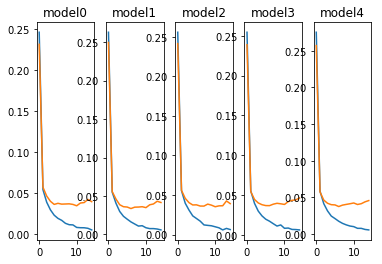

In [8]:
fig = plt.figure()
for m in range(num_models):
    loss_history = fig.add_subplot(1,5,m+1)
    loss_history.plot(model_tr_loss_history[:,m], label = 'tr_loss')
    loss_history.plot(model_val_loss_history[:,m], label = 'val_loss')
    loss_history.title.set_text('model' + str(m))

#### prediction 

In [9]:
# test set accuracy
# accuracy of each model 
for m_idx,m in enumerate(models):
    print('model{} accuracy : {:.4%}'.format(m_idx, m.get_accuracy(mnist.test.images, mnist.test.labels)))

model0 accuracy : 99.1500%
model1 accuracy : 99.1300%
model2 accuracy : 99.1500%
model3 accuracy : 99.1300%
model4 accuracy : 99.1600%


In [10]:
# majority voting (bagging)
from collections import Counter

predict_result = []
for m in models:
    predict_result.append(np.argmax(m.predict(mnist.test.images), axis = 1))
predict_result = np.asarray(predict_result)

def majority_voting(result_1d):
    return Counter(result_1d).most_common(1)[0][0]

ensemble_prediction = np.apply_along_axis(majority_voting, axis = 0, arr = predict_result)
ensemble_accuracy = np.mean(np.equal(ensemble_prediction, np.argmax(mnist.test.labels, axis = 1)))
print(ensemble_accuracy)

0.9934
